# Set up -- just run all this stuff

In [25]:
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder
import pickle
import os
import torch as t
from circuits.chess_utils import decode_list
from IPython.display import HTML
from circuits.chess_utils import pgn_string_to_board
from huggingface_hub import hf_hub_download
from circuits.utils import (
    chess_hf_dataset_to_generator,
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

# device = 'cuda:0'

repo_dir = '/home/can/chess-gpt-circuits'
# repo_dir = "/home/adam/chess-gpt-circuits/"

autoencoder_group_name = 'chess-trained_model-layer_5-2024-05-23'

# download data from huggingface if needed
if not os.path.exists(f'{repo_dir}/autoencoders/{autoencoder_group_name}'):
    hf_hub_download(repo_id='adamkarvonen/chess_saes', filename=f'{autoencoder_group_name}.zip', local_dir=f'{repo_dir}/autoencoders')
    # unzip the data
    os.system(f'unzip {repo_dir}/autoencoders/{autoencoder_group_name}.zip -d autoencoders')

device = 'cuda:0'

In [26]:
# load SAE
ae_type = 'p_anneal'
trainer_idx = 24

ae_path = f'{repo_dir}/autoencoders/{autoencoder_group_name}/chess-trained_model-layer_5-{ae_type}/trainer{trainer_idx}/'

ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
# ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')


# load information about features
def to_device(d, device=device):
    if isinstance(d, t.Tensor):
        return d.to(device)
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}
    
with open(os.path.join(ae_path, 'indexing_find_dots_indices_n_inputs_1000_results.pkl'), 'rb') as f:
    results = pickle.load(f)
results = to_device(results)

In [27]:
filter_function = 'board_to_piece_state'
prec = results[filter_function]['on'] / (results[filter_function]['all']+1e-8)
prec = prec[1] # T=1 is a reasonable choice
max_values, max_indices = prec.max(dim=0)

In [28]:
# White knight on F3 corresponds to [5, 2, 8]
board_state_idx = [5, 2, 8]
print(max_values[board_state_idx[0], board_state_idx[1], board_state_idx[2]])
print(max_indices[board_state_idx[0], board_state_idx[1], board_state_idx[2]])

tensor(1., device='cuda:0')
tensor(3547, device='cuda:0')


## Visualize promising feature

In [29]:
# load model
layer = 5
othello = False
batch_size = 10
total_games_size = batch_size * 50

if not othello:
    with open("models/meta.pkl", "rb") as f:
        meta = pickle.load(f)

    context_length = 256
    model_name = "adamkarvonen/8LayerChessGPT2"
    dataset_name = "adamkarvonen/chess_sae_text"
    data = chess_hf_dataset_to_generator(
        dataset_name, meta, context_length=context_length, split="train", streaming=True
    )
    model_type = "chess"
else:
    context_length = 59
    model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
    dataset_name = "taufeeque/othellogpt"
    data = othello_hf_dataset_to_generator(
        dataset_name, context_length=context_length, split="train", streaming=True
    )
    model_type = "othello"

model = get_model(model_name, device)
submodule = get_submodule(model_name, layer, model)

# load data
games_batch = [next(data) for _ in range(total_games_size)]
games_batch = t.tensor(games_batch, device=device)
games_batch.shape

torch.Size([500, 256])

In [30]:
# functions for visualizing PNG string
def shade(value, max_value):
    if abs(value) > max_value:
        raise ValueError("Absolute value must be less than or equal to max_value.")
    
    normalized_value = value / (max_value + 1e-9)
    
    if normalized_value < 0:
        # Red shade for negative values
        red = 255
        green = int(255 * (1 + normalized_value))
        blue = int(255 * (1 + normalized_value))
    else:
        # Blue shade for positive values
        red = int(255 * (1 - normalized_value))
        green = int(255 * (1 - normalized_value))
        blue = 255
    
    # White color for zero value
    if value == 0:
        red = green = blue = 255
    
    # Convert RGB values to hex color code
    hex_color = "#{:02x}{:02x}{:02x}".format(red, green, blue)
    
    return hex_color

def visualize_pgn(tokens, meta, activations, max_value, prefix=''):
    html_elements = []
    for token, act in zip(tokens, activations):
        hex_color = shade(act, max_value)
        s = decode_list(meta, [token])[0]
        s = s.replace(' ', '&nbsp;')
        html_element = f'<span style="background-color: {hex_color}; color: black">{s}</span>'
        html_elements.append(html_element)
    
    combined_html = ''.join(html_elements)
    combined_html = prefix + combined_html
    return HTML(combined_html)

In [31]:
# visualize top k max activating contexts for given feature
def visualize(model, ae, games_batch, feat_idx, k=20):
    tokens = t.zeros(total_games_size, context_length).to(device)
    f = t.zeros(total_games_size, context_length).to(device)
    for i in range(0, total_games_size, batch_size):
        batch_tokens = games_batch[i:i+batch_size]
        with t.no_grad(), model.trace(batch_tokens):
            x = submodule.output[0]
            batch_f = ae.encode(x).save()
        f[i:i+batch_size] = batch_f.value[...,feat_idx]
        tokens[i:i+batch_size] = batch_tokens
    # The following 5 lines don't batch the data and use more memory
    # tokens = games_batch
    # with t.no_grad(), model.trace(tokens):
    #     x = submodule.output[0]
    #     f = ae.encode(x).save()
    # f = f.value[...,feat_idx]

    def unravel_index(indices, shape):
        out = []
        for dim in reversed(shape):
            out.append(indices % dim)
            indices = indices // dim
        return tuple(reversed(out))

    # get indices of top k exemplars
    flattened_f = f.flatten()
    top_values, top_indices_flattened = t.topk(flattened_f, k)
    top_indices = unravel_index(top_indices_flattened, f.shape)

    # compile top contexts and activations
    contexts, activations = [], []
    for i in range(k):
        context_idx, token_idx = top_indices[0][i].item(), top_indices[1][i].item()
        contexts.append(tokens[context_idx, :token_idx+1].tolist())
        activations.append(f[context_idx, :token_idx+1].tolist())
    max_value = max([abs(x) for act in activations for x in act])

    for context, activation in zip(contexts, activations):
        pgn_string = decode_list(meta, context)
        display(visualize_pgn(context, meta, activation, max_value, prefix='feature activations: '))
        print('most recent valid board:')
        while pgn_string:
            try:
                display(pgn_string_to_board(pgn_string))
                break
            except:
                pgn_string = pgn_string[:-1]

# Here's the interactive part

Key for mapping from the last entry of the board state tensor to pieces:
* 0 => black king
* 1 => black queen
* 2 => black rook
* 3 => black bishop
* 4 => black knight
* 5 => black pawn
* 6 => empty
* 7 => white pawn
* 8 => white knight
* 9 => white bishop
* 10 => white rook
* 11 => white queen
* 12 => white king

most recent valid board:


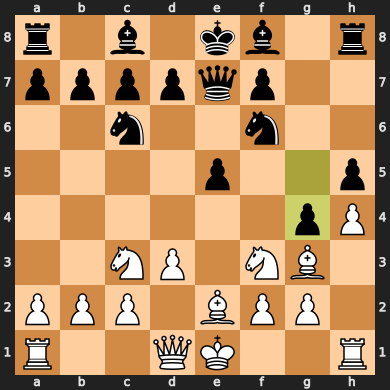

most recent valid board:


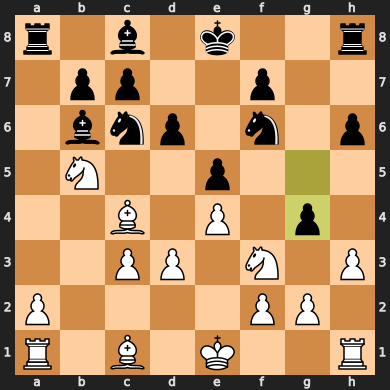

most recent valid board:


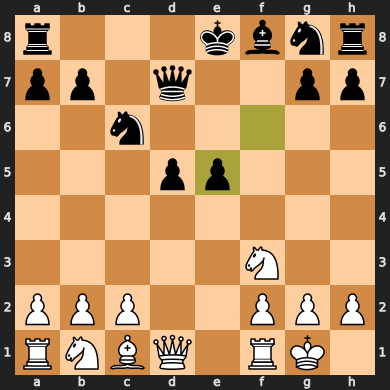

most recent valid board:


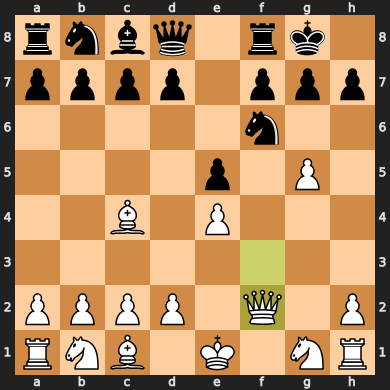

most recent valid board:


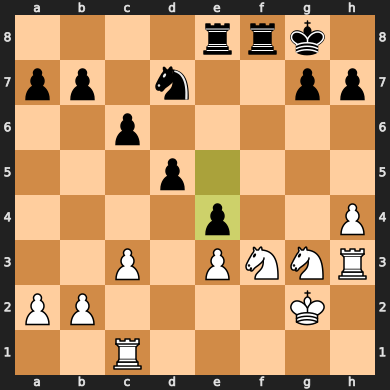

most recent valid board:


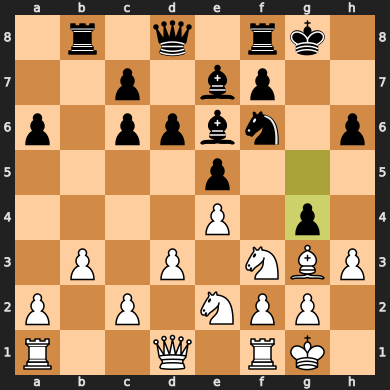

most recent valid board:


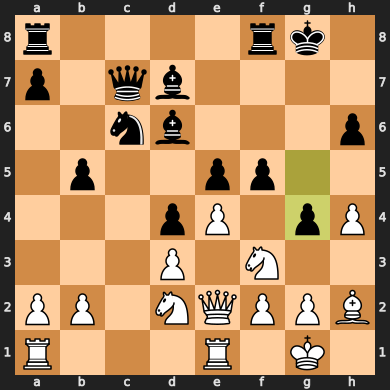

most recent valid board:


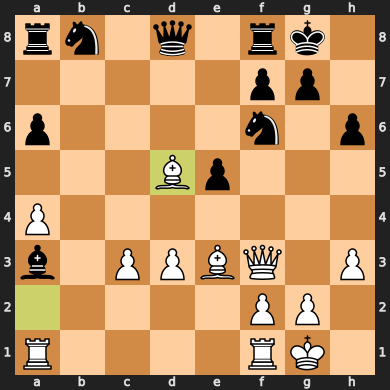

most recent valid board:


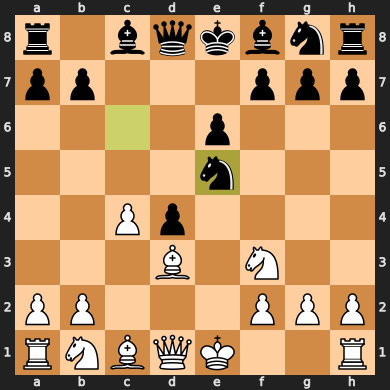

most recent valid board:


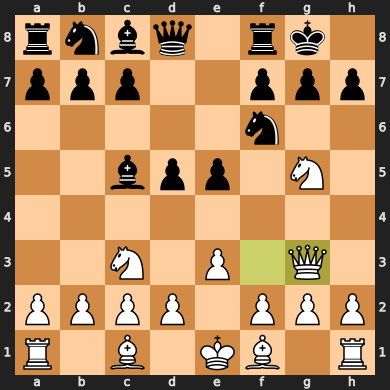

most recent valid board:


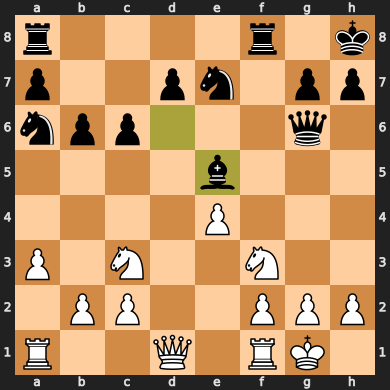

most recent valid board:


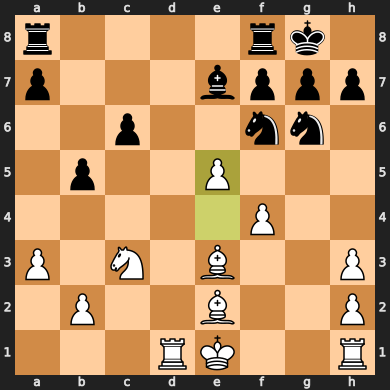

most recent valid board:


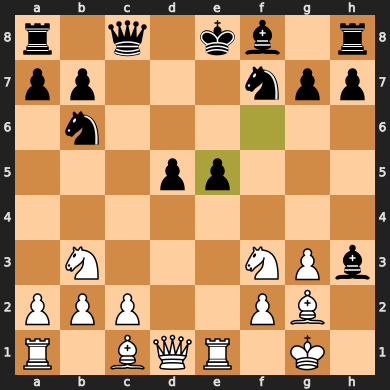

most recent valid board:


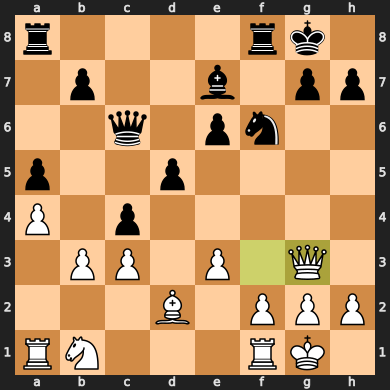

most recent valid board:


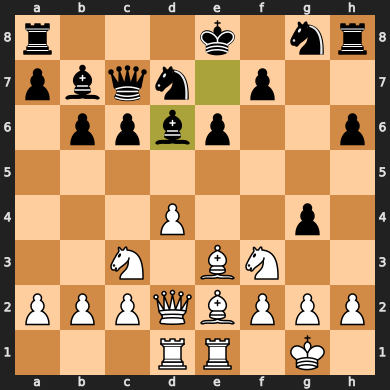

most recent valid board:


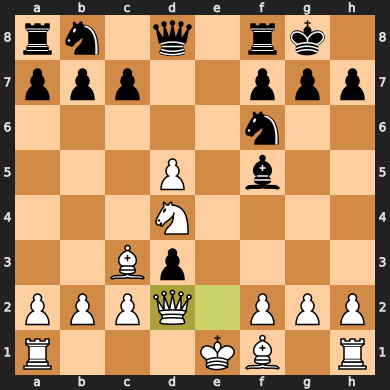

most recent valid board:


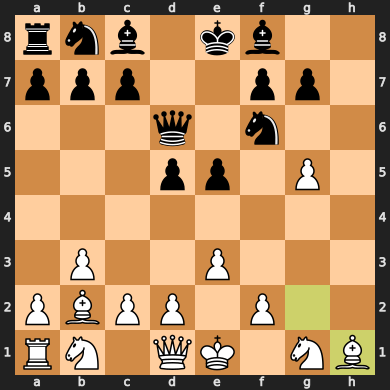

most recent valid board:


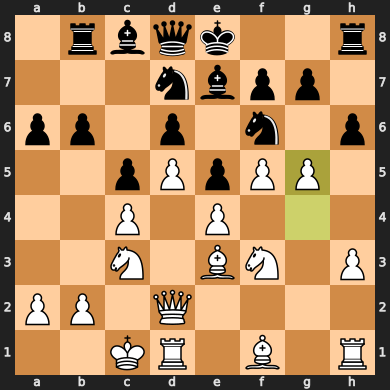

most recent valid board:


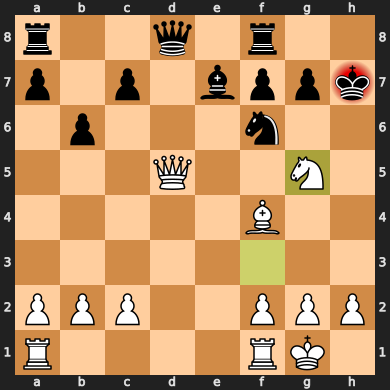

most recent valid board:


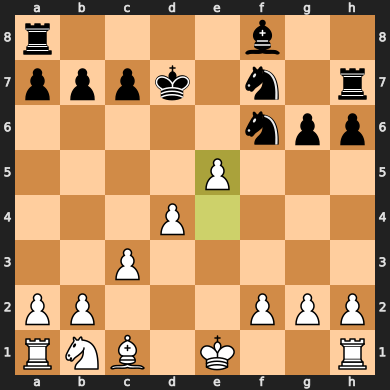

In [33]:
# set idx to be the index of the (alive) feature you want to visualize
idx = 6128
feat_idx = results['alive_features'][idx]
# feat_idx = idx
# print("Board states that the feature classifies according to Adam's measurements:")
# print((results['board_to_piece_state'][0][idx] > .95).nonzero())
# print("Number of such board states:")
# print((results['board_to_piece_state'][0][idx] > .95).sum())

visualize(model, ae, games_batch, feat_idx, k=20)